In [1]:
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt
idx = pd.IndexSlice
pd.set_option("display.max_rows",101)
pd.set_option('expand_frame_repr', False)
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

# MRChem benchmark calculations

This notebook presents benchmark timings for the MRChem program on a set of molecular calculations using a variable number of CPU cores. The test systems are standard linear alkane chains $C_nH_{2n+2}$, with $n$ ranging from 2 to 350, as well as the Caffeine ($C_{8}H_{10}N_{4}O_{2}$) and Valinomycine ($C_{54}H_{90}N_{6}O_{18}$) molecules. The main purpose of this data is to monitor the development of the code performance between different version, but it will also provide a reference for users to check if the code has been properly installed and runs reasonably on their system. Not all molecular systems will be available in the data, which mirrors the current limitations of the code when it comes to system size and numerical precision. Only a small selection of the data will be presented below, but further details are available by digging into the raw data.

## MRChem SCF cycle

The Self-Consistent Field (SCF) cycle in MRChem contains the following steps:

- Building Fock operator
- Calculating Fock matrix
- Rotating orbitals (diagonalization or localization)
- Calculating SCF energy
- Applying Helmholtz operator
- Applying iterative subspace acceleration (KAIN)
- Löwdin orthonormalization

and each of these may have sub steps that can be extracted from the data below. The calculations are performed using one of the following methods:

- Hartree (to show the performance of the backbone SCF algorithm + Coulomb interaction)
- Hartree-Fock (to show the performance of the exact exchange operator)
- DFT-PBE (to show the performance of the density functional integrator)

## Parallel performance

The following table presents timings (in sec) for the different parts of a single SCF cycle for the Caffeine ($C_{8}H_{10}N_{4}O_{2}$) molecule at numerical precision $\epsilon=10^{-5}$, using the Hartree method. The calculations are using an increasing number of MPI processes and OMP threads per process. The molecule has 102 electrons and 51 doubly occupied molecular orbitals.

In [3]:
mol='caffeine'
hybrid_frame = pd.read_csv("caffeine-hartree/scf.csv", index_col=[0,1,2])
hybrid_frame.loc[mol,:,:]

Localize  SCF energy  Helmholtz  Lowdin      KAIN  Fock operator  Fock matrix  Total SCF
MPI OMP                                                                                          
1   1    460.1660   260.09700  5384.3600     NaN  51.19210       267.8550     355.5390   7388.980
    2    299.5310   130.25900  2697.2800     NaN  29.07560       134.7150     220.1750   3867.190
    4    209.6320    67.02760  1366.4200     NaN  18.55670        67.9688     145.1540   2093.320
    8    167.6260    36.20350   719.8600     NaN  13.93810        36.0718     110.3440   1242.720
    16   147.9460    21.04090   408.0300     NaN  12.10750        20.6072      93.9844    833.527
2   1    249.9090   132.91600  2819.0600     NaN  25.41010       230.2210     193.4330   3979.620
    16   118.0420    14.94440   269.0300     NaN   7.05987        27.3405      72.5932    607.493
4   1    197.7920    75.45210  1893.7400     NaN  17.07280       283.0080     121.6580   2810.480
    16    76.3807     6.34539   173.7240     NaN   3.91472        28.7328      39.2295    388.451
8   1    120.0520    45.51970  1046.9300     NaN   9.29157       237.8980      90.6737   1697.820
    16    53.9923     4.54194    94.2679     NaN   2.33863        29.8927      25.9839    253.364
16  1     94.8919    22.81410   533.4670     NaN   5.51442       272.2160      59.0906   1104.140
    16    44.2113     2.99324    58.8411     NaN   1.15669        28.2194      24.6596    195.069

## OpenMP scaling

The following table presents timings (in sec) on a single compute node for the different parts of a single SCF cycle for the Caffeine ($C_{8}H_{10}N_{4}O_{2}$) molecule at numerical precision $\epsilon=10^{-5}$, using the Hartree method. The molecule has 102 electrons and 51 doubly occupied molecular orbitals.

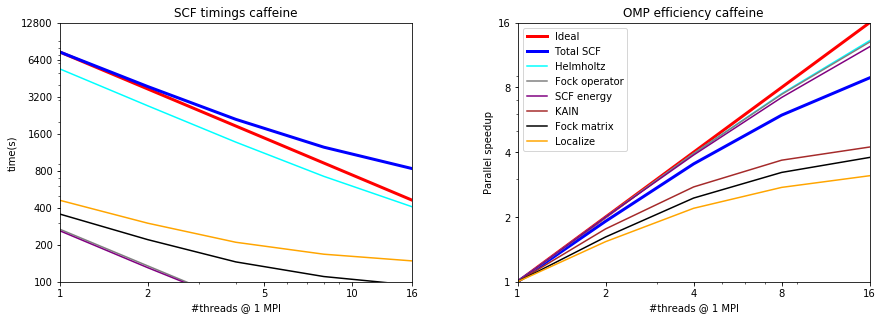

,Localize,SCF energy,Helmholtz,Lowdin,KAIN,Fock operator,Fock matrix,Total SCF
OMP,,,,,,,,
1,460.166,260.0970,5384.36,NaN,51.1921,267.8550,355.5390,7388.980
2,299.531,130.2590,2697.28,NaN,29.0756,134.7150,220.1750,3867.190
4,209.632,67.0276,1366.42,NaN,18.5567,67.9688,145.1540,2093.320
8,167.626,36.2035,719.86,NaN,13.9381,36.0718,110.3440,1242.720
16,147.946,21.0409,408.03,NaN,12.1075,20.6072,93.9844,833.527


In [4]:
mpi=1
mol='caffeine'
omp_frame = pd.read_csv("caffeine-hartree/scf.csv", index_col=[0,1,2])
omp_series = omp_frame.loc[mol,mpi]

plt.subplot(121)
plt.title('SCF timings ' + mol)
plt.plot(omp_series.index, mpi*omp_series['Total SCF'][mpi]/omp_series.index, c='red', lw=3, label='Ideal')
plt.plot(omp_series['Total SCF'], c='blue', lw=3)
plt.plot(omp_series['Helmholtz'], c='cyan')
plt.plot(omp_series['Localize'], c='orange')
plt.plot(omp_series['Fock matrix'], c='black')
plt.plot(omp_series['Fock operator'], c='gray')
plt.plot(omp_series['SCF energy'], c='purple')
plt.yscale('log')
plt.xscale('log')
plt.axis([1, 16, 100, 12800])
plt.yticks([100, 200, 400, 800, 1600, 3200, 6400, 12800], [100, 200, 400, 800, 1600, 3200, 6400, 12800])
plt.xticks([1, 2, 5, 10, 16], [1, 2, 5, 10, 16])
plt.ylabel('time(s)')
plt.xlabel('#threads' + ' @ ' + str(mpi) + ' MPI')

plt.subplot(122)
plt.title('OMP efficiency ' + mol)
plt.plot(omp_series.index, omp_series.index, c='red', lw=3, label='Ideal')
plt.plot(mpi*omp_series['Total SCF'][mpi]/omp_series['Total SCF'], c='blue', lw=3)
plt.plot(mpi*omp_series['Helmholtz'][mpi]/omp_series['Helmholtz'], c='cyan')
plt.plot(mpi*omp_series['Fock operator'][mpi]/omp_series['Fock operator'], c='gray')
plt.plot(mpi*omp_series['SCF energy'][mpi]/omp_series['SCF energy'], c='purple')
plt.plot(mpi*omp_series['KAIN'][mpi]/omp_series['KAIN'], c='brown')
plt.plot(mpi*omp_series['Fock matrix'][mpi]/omp_series['Fock matrix'], c='black')
plt.plot(mpi*omp_series['Localize'][mpi]/omp_series['Localize'], c='orange')
plt.legend(loc='upper left')
plt.yscale('log')
plt.xscale('log')
plt.axis([1, 16, 1, 16])
plt.yticks([1, 2, 4, 8, 16], [1, 2, 4, 8, 16])
plt.xticks([1, 2, 4, 8, 16], [1, 2, 4, 8, 16])
plt.ylabel('Parallel speedup')
plt.xlabel('#threads' + ' @ ' + str(mpi) + ' MPI')

plt.subplots_adjust(top=1.0, bottom=0.1, right=2, wspace=.30)
plt.show()
omp_frame.loc[mol,mpi,:]

## MPI scaling

The following table presents timings (in sec) for the different parts of a single SCF cycle for the Caffeine ($C_{8}H_{10}N_{4}O_{2}$) molecule at numerical precision $\epsilon=10^{-5}$, using the Hartree method. The calculations are using an increasing number of MPI processes with fixed a single OMP threads per process. The molecule has 102 electrons and 51 doubly occupied molecular orbitals.

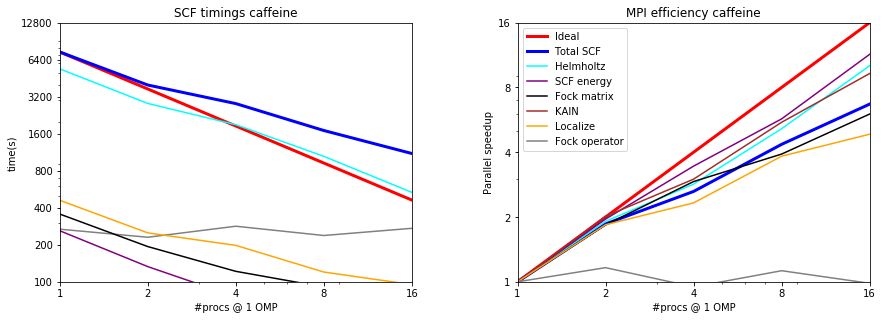

,Localize,SCF energy,Helmholtz,Lowdin,KAIN,Fock operator,Fock matrix,Total SCF
MPI,,,,,,,,
1,460.1660,260.0970,5384.360,NaN,51.19210,267.855,355.5390,7388.98
2,249.9090,132.9160,2819.060,NaN,25.41010,230.221,193.4330,3979.62
4,197.7920,75.4521,1893.740,NaN,17.07280,283.008,121.6580,2810.48
8,120.0520,45.5197,1046.930,NaN,9.29157,237.898,90.6737,1697.82
16,94.8919,22.8141,533.467,NaN,5.51442,272.216,59.0906,1104.14


In [5]:
omp=1
ref=1
mol='caffeine'
mpi_frame = pd.read_csv("caffeine-hartree/scf.csv", index_col=[0,2,1])
mpi_series = mpi_frame.loc[mol,omp]

plt.subplot(121)
plt.title('SCF timings ' + mol)
plt.plot(mpi_series.index, ref*mpi_series['Total SCF'][ref]/mpi_series.index, c='red', lw=3, label='Ideal')
plt.plot(mpi_series['Total SCF'], c='blue', lw=3)
plt.plot(mpi_series['Helmholtz'], c='cyan')
plt.plot(mpi_series['Fock operator'], c='gray')
plt.plot(mpi_series['Localize'], c='orange')
plt.plot(mpi_series['Fock matrix'], c='black')
plt.plot(mpi_series['SCF energy'], c='purple')
plt.yscale('log')
plt.xscale('log')
plt.axis([1, 16, 100, 12800])
plt.yticks([100, 200, 400, 800, 1600, 3200, 6400, 12800], [100, 200, 400, 800, 1600, 3200, 6400, 12800])
plt.xticks([1, 2, 4, 8, 16], [1, 2, 4, 8, 16])
plt.ylabel('time(s)')
plt.xlabel('#procs' + ' @ ' + str(omp) + ' OMP')

plt.subplot(122)
plt.title('MPI efficiency ' + mol)
plt.plot(mpi_series.index, mpi_series.index, c='red', lw=3, label='Ideal')
plt.plot(ref*mpi_series['Total SCF'][ref]/mpi_series['Total SCF'], c='blue', lw=3)
plt.plot(ref*mpi_series['Helmholtz'][ref]/mpi_series['Helmholtz'], c='cyan')
plt.plot(ref*mpi_series['SCF energy'][ref]/mpi_series['SCF energy'], c='purple')
plt.plot(ref*mpi_series['Fock matrix'][ref]/mpi_series['Fock matrix'], c='black')
plt.plot(ref*mpi_series['KAIN'][ref]/mpi_series['KAIN'], c='brown')
plt.plot(ref*mpi_series['Localize'][ref]/mpi_series['Localize'], c='orange')
plt.plot(ref*mpi_series['Fock operator'][ref]/mpi_series['Fock operator'], c='gray')
plt.legend(loc='upper left')
plt.yscale('log')
plt.xscale('log')
plt.axis([1, 16, 1, 16])
plt.yticks([1, 2, 4, 8, 16], [1, 2, 4, 8, 16])
plt.xticks([1, 2, 4, 8, 16], [1, 2, 4, 8, 16])
plt.ylabel('Parallel speedup')
plt.xlabel('#procs' + ' @ ' + str(omp) + ' OMP')

plt.subplots_adjust(top=1.0, bottom=0.1, right=2, wspace=.30)
plt.show()
mpi_frame.loc[mol,omp]

## Hybrid MPI/OpenMP scaling

The following table presents timings (in sec) for the different parts of a single SCF cycle for the Caffeine ($C_{8}H_{10}N_{4}O_{2}$) molecule at numerical precision $\epsilon=10^{-5}$, using the Hartree method. The calculations are using an increasing number of MPI processes with fixed 10 OMP threads per process. The molecule has 102 electrons and 51 doubly occupied molecular orbitals.

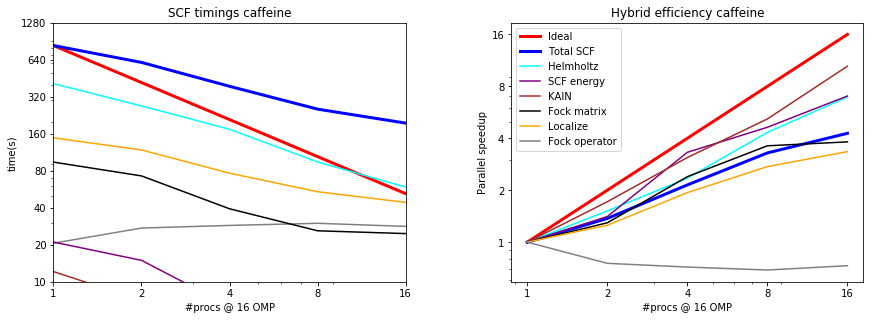

,Localize,SCF energy,Helmholtz,Lowdin,KAIN,Fock operator,Fock matrix,Total SCF
MPI,,,,,,,,
1,147.9460,21.04090,408.0300,NaN,12.10750,20.6072,93.9844,833.527
2,118.0420,14.94440,269.0300,NaN,7.05987,27.3405,72.5932,607.493
4,76.3807,6.34539,173.7240,NaN,3.91472,28.7328,39.2295,388.451
8,53.9923,4.54194,94.2679,NaN,2.33863,29.8927,25.9839,253.364
16,44.2113,2.99324,58.8411,NaN,1.15669,28.2194,24.6596,195.069


In [6]:
omp=16
ref=1
mol='caffeine'
hybrid_frame = pd.read_csv("caffeine-hartree/scf.csv", index_col=[0,2,1])
hybrid_series = hybrid_frame.loc[mol,omp]

plt.subplot(121)
plt.title('SCF timings ' + mol)
plt.plot(hybrid_series.index, ref*hybrid_series['Total SCF'][ref]/omp_series.index, c='red', lw=3)
plt.plot(hybrid_series['Total SCF'], c='blue', lw=3)
plt.plot(hybrid_series['Helmholtz'], c='cyan')
plt.plot(hybrid_series['Localize'], c='orange')
plt.plot(hybrid_series['Fock operator'], c='gray')
plt.plot(hybrid_series['Fock matrix'], c='black')
plt.plot(hybrid_series['SCF energy'], c='purple')
plt.plot(hybrid_series['KAIN'], c='brown')
plt.yscale('log')
plt.xscale('log')
plt.axis([1, 16, 10, 20])
plt.yticks([10, 20, 40, 80, 160, 320, 640, 1280], [10, 20, 40, 80, 160, 320, 640, 1280])
plt.xticks([1, 2, 4, 8, 16], [1, 2, 4, 8, 16])
plt.ylabel('time(s)')
plt.xlabel('#procs' + ' @ ' + str(omp) + ' OMP')

plt.subplot(122)
plt.title('Hybrid efficiency ' + mol)
plt.plot(hybrid_series.index, hybrid_series.index, c='red', lw=3, label='Ideal')
plt.plot(ref*hybrid_series['Total SCF'][ref]/hybrid_series['Total SCF'], c='blue', lw=3)
plt.plot(ref*hybrid_series['Helmholtz'][ref]/hybrid_series['Helmholtz'], c='cyan')
plt.plot(ref*hybrid_series['SCF energy'][ref]/hybrid_series['SCF energy'], c='purple')
plt.plot(ref*hybrid_series['KAIN'][ref]/hybrid_series['KAIN'], c='brown')
plt.plot(ref*hybrid_series['Fock matrix'][ref]/hybrid_series['Fock matrix'], c='black')
plt.plot(ref*hybrid_series['Localize'][ref]/hybrid_series['Localize'], c='orange')
plt.plot(ref*hybrid_series['Fock operator'][ref]/hybrid_series['Fock operator'], c='gray')
plt.legend(loc='upper left')
plt.yscale('log')
plt.xscale('log')
#plt.axis([1, 16, 1, 16])
plt.yticks([1, 2, 4, 8, 16], [1, 2, 4, 8, 16])
plt.xticks([1, 2, 4, 8, 16], [1, 2, 4, 8, 16])
plt.ylabel('Parallel speedup')
plt.xlabel('#procs' + ' @ ' + str(omp) + ' OMP')

plt.subplots_adjust(top=1.0, bottom=0.1, right=2, wspace=.30)
plt.show()
mpi_frame.loc[mol,omp,:]